## TODO
- write gradient check
    - also check the gradient values of the weights. Are the weights chaging?
- classification error is not working
- and then start testing models

In [1]:
import seaborn as sb
import numpy as np
import pdb
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

/home/chahuja/env/tf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Load Data
train = np.matrix(np.genfromtxt('digitstrain.txt', delimiter=','))
test = np.matrix(np.genfromtxt('digitstest.txt', delimiter=','))
val = np.matrix(np.genfromtxt('digitsvalid.txt', delimiter=','))

In [3]:
# Prepare data for training, validation and testing
NUM_CLASSES = 10 ## hardcoded
## converting ground truths to one-hot encoding
def cat_to_one_hot(vec):
  vec = vec.astype(int) ## changing type to int as these are indices for the one-hot vector
  return np.matrix(np.eye(NUM_CLASSES)[vec])

train_gt = cat_to_one_hot(train[:,-1])
test_gt = cat_to_one_hot(test[:,-1])
val_gt = cat_to_one_hot(val[:,-1])

train = train[:,:-1]
test = test[:,:-1]
val = val[:,:-1]

## Plotting Image of a training input

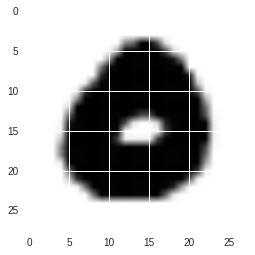

In [4]:
# Plotting the image
plt.imshow(train[0].reshape((28,28)))
## The image is squeezed row-wise

## Class description
```sh
graph - [num_nodes(int), num_nodes(int), ...]
each layer ends with sigmoid
graph ends with softmax and crossentropy loss
```

In [5]:
# Basic loss/activation functions and their gradients which are codenamed "inv"
# These functions are defined with input as numpy.matrix format.
# things may go haywire if numpy.array is used 
# even though numpy.matrix inherits properties from numpy.array
def cross_entropy_loss(vec, gt):
  return -np.multiply(gt,np.log(vec)).sum()/vec.shape[0] ## take the average

def classification_error(vec,gt):
  #pdb.set_trace()
  dif = abs(np.argmax(vec,axis=1)-np.argmax(gt,axis=1))
  err = np.ceil((1.0*dif)/max(dif))
  relative_err = (1.0*err.sum())/len(err)
  return relative_err*100

def sigmoid(mat):
  return 1./(1+ np.exp(-mat))

def inv_sigmoid(mat):
  return np.multiply(sigmoid(mat),(1-sigmoid(mat)))

def softmax(vec):
  return np.concatenate(
    tuple([np.exp(vec[i,:])*1./np.exp(vec[i,:]).sum() for i in range(vec.shape[0])])
    , axis = 0)

def inv_softmax_with_loss(vec, gt):
  # gt - ground truth in one hot vector format
  if (vec.shape != gt.shape):
    raise Exception("Prediction and Expected Values must have the same dimensions")
    
  return softmax(vec) - gt

def relu(value):
  if (value<=0):
    return 0
  else:
    return value

In [6]:
class history(object):
  def __init__(self):
    self.train_loss = list()
    self.val_loss = list()

  def add(self,train_loss, val_loss):
    self.train_loss.append(train_loss)
    self.val_loss.append(val_loss)

## Model class NN

In [7]:
class NN(object):
  def __init__(self,graph):
    self.graph = graph
    self.weights = list()
    self.hist = history()
    self.v = list() ## momentum
    
    prev_dim = -1
    for dim in self.graph:
        if (prev_dim > 0):
          # set the high and low bounds for the random initialization 
          # based on glorot's rule
          high = np.sqrt(6.0/(prev_dim + dim))
          low = -high
          # prev_dim + 1 to include a row for bias 
          self.weights.append(np.random.uniform(low=low,high=high,size=(prev_dim+1,dim)))
          ## momentum has the same dimension as the weight matrices
          self.v.append(np.matrix(np.zeros_like(self.weights[-1])))
        prev_dim = dim
    
    self.num_layers = len(self.weights)

  def plot(self):
    #sb.pointplot(x="num_epochs", y="entropy_loss", data=[self.hist.train_loss,self.hist.val_loss]);
    plt.plot(self.hist.train_loss,range(len(self.hist.train_loss)), 'r--')
    plt.plot(self.hist.val_loss,range(len(self.hist.val_loss)), 'g+-')

  def forward(self,X,limit = 0, activation = False):
    # We use the forward function to calculate the forward prop
    ## while training the model, various segments of the forward prop are required
    ## which need to be extracted at the right times
    # "limit" and "activation" define the layers that have to be removed from the end
    ## limit = 0 and activation=True implies complete calculation
    ## limit = 0 and activation=False ignores the softmax function but calculates till last layer
    ## limit = 1 and activation=True implies calculation till second-last layer w/ sigmoid
    ## limit = 1 and activation=False implies calculation till second-last layer w/o sgimoid
    ## now the limit belongs to [0,len(NN.weights)-1], hence with other values it will give junk
    # raise havoc if the limits are not correct
    if(limit > self.num_layers or limit < 0):
      raise Exception("Limits of the network are out of bounds")
    # add a column of ones to take care of the bias only if we do not need the input layer
    if((limit == self.num_layers and activation == True) or limit < self.num_layers):
      X = np.concatenate((X,np.ones_like(X[:,0])), axis = 1)
    # Converting input to matrix form
    X = np.mat(X)
    
    # limits
    ## 0 -> -1
    ## 1 -> -1
    ## 2 -> -2 and so on which generalizes to relu(limit-1)-1
    limits = range(self.num_layers-relu(limit-1)-1)
    #print limits
    for k in limits:
      X = X*np.mat(self.weights[k]) ## Linear
      ## if activation=False skip the non-linear part
      ## if k is the final element of the limits only then break 
      ## if limit is not 0, then all the layers must be taken into consideration
      if (activation == False and k == limits[-1] and limit != 0):
        break
      X = sigmoid(X) ## Non-Linear
      X = np.concatenate((X,np.ones_like(X[:,0])), axis = 1)
    
    # if the limit is anything apart the last layer, return the calculated values
    if (limit > 0):
      return X
    
    X = X*np.mat(self.weights[-1]) ## Linear
    if (activation == True):
      return softmax(X) ## Non-Linear
    else: 
      return X
  
  # implements one iteration of backpropogation through the network
  ## it has to use forward() to estimate gradient values at each layer
  ## the gradient values for every matrix are returned as a list of matrices
  ## which will be used for optimizing the model via stochastic/batch/mini-batch descent
  # Note: the gradients are calculated based on the original set of weights provided as X
  ## and all the weights ar updated at the end of a complete back prob
  # -------------------------------------------------------------------------------
  # Variables
  # ---------
  # grad_W = gradients w.r.t. weights including bias
  # grad_H = gradients w.r.t. hidden layers
  # grad_A = gradients w.r.t. pre-activation layer
  # All of these variables are lists and updated as the backprob traverses through 
  ## different layers
  # -------------------------------------------------------------------------------
  def backprob(self, X, gt):
    self.grad_W = list()
    grad_H = list()
    grad_A = list()
    
    ## initializing first gradient
    grad_A.append(inv_softmax_with_loss(self.forward(X), gt))
    for k in range(self.num_layers):
      self.grad_W.append(self.forward(X, k+1, True).T * grad_A[k])
      ## We do not need the bias layer to update the gradients so we do not keep it
      grad_H.append(self.weights[self.num_layers-k-1][:-1,:] * grad_A[k].T) 
      grad_A.append(np.multiply(grad_H[k].T,inv_sigmoid(self.forward(X,k+1))))

    ## reverse the list of gradients as they were stored in the order of backprob
    self.grad_W.reverse()
    
  ## gradient updates which requires learning rate(lr) and momentum(mm)
  def grad_descent(self, X, gt, lr=0.1, mm=0):
    ## calculating gradients
    self.backprob(X, gt)
    ## updating gradients
    for k in range(self.num_layers):
      self.v[k] = self.v[k] * mm - lr * self.grad_W[k]
      self.weights[k] = self.weights[k] + self.v[k]

## Saving and loading the model

In [8]:
def save_model(model, filename):
  fl = open(filename,'wb')
  pkl.dump(model,fl)
  
def load_model(filename):
  fl = open(filename, 'rb')
  return pkl.load(fl)

In [12]:
model = NN([784,100, 10])
#model.forward(train[0:2,:-1],0, True).shape
#model.forward(train[0:2,:-1],1, True).shape
model.forward(train[0:2],1).shape

(2, 100)

In [ ]:
for i in tqdm(range(1000)):
  #sample = list(np.floor(np.random.uniform(high=2999,low=0,size=(1000,))).astype(int))
  #strain = np.matrix(np.array(train)[sample])
  #strain_gt = np.matrix(np.array(train_gt)[sample])
  model.grad_descent(train, train_gt, lr = 0.001)
  pdb.set_trace()
  train_pred = model.forward(train,activation=True)
  val_pred = model.forward(val,activation=True)
  model.hist.add(cross_entropy_loss(train_pred, train_gt),
                cross_entropy_loss(val_pred, val_gt))
  print("train error: %f, %f") %(model.hist.train_loss[-1],classification_error(train_pred,train_gt))
  print("val error: %f, %f") %(model.hist.val_loss[-1],classification_error(val_pred,val_gt))
  #print(model.weights[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

> <ipython-input-13-31c190bc2a61>(7)<module>()
-> train_pred = model.forward(train,activation=True)


In [ ]:
    train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_loss, 'r--', label='Train')
    val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_loss, 'g-', label="Val")
    plt.xlabel('No. of Epochs')
    plt.ylabel('mean(Entropy Loss)')
    #plt.legend([train_plt,val_plt])
    #plt.axis([100,600, 0, 5])


In [ ]:
classification_error(model.forward(val, activation=True),val_gt)

In [ ]:
model.grad_W

In [ ]:
#np.matrix(np.zeros(10,1)[train[0,-1]])
b = np.zeros((10,1))
b[int(train[0,-1])] = 1
b = np.matrix(b)
b

In [ ]:
sb.distplot(model.forward(train[0:2,:-1],2)[0])
model.num_layers
#model.forward(train[0:2,:-1],2)[0,:-1] - train[0:1,:-1]

In [ ]:
i = 2
sb.distplot(model.weights[i].reshape((np.prod(model.weights[i].shape),)))

In [ ]:
a = np.floor(np.random.uniform(high=2999,low=0,size=(100,))).astype(int)

In [ ]:
list(a)

In [ ]:
a = np.array([1,2,3,4,5])

In [ ]:
a[[2,3]]

In [ ]:
sample = list(np.floor(np.random.uniform(high=2999,low=0,size=(100,))).astype(int))
np.array(train)[sample]

In [ ]:
a = np.matrix([[1,2,3],[4,5,6]])

In [ ]:
a

In [ ]:
np.argmax(a, axis=1)